# Instacart-Products Buy Again Prediction
## Define the Problem
The goal of this project is to examine the dataset of Instacart online grocery shopping orders and use this data to build and test models for predicting products that a user will buy again.

In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# Lets load the data and try to understand to the data provided in the excel files.
path = os.getcwd()
os.chdir('C:/Users/15832/Downloads/projects/Advisory/dsprj')
files = os.listdir(path)
files
orders_df = pd.read_csv('orders.csv')
products_df = pd.read_csv('products.csv')
order_products_prior_df = pd.read_csv('order_products__prior.csv')
order_products_train_df = pd.read_csv('order_products__train.csv')
aisles_df = pd.read_csv('aisles.csv')
departments_df = pd.read_csv('departments.csv')

# Data Discovery

In [3]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Orders.csv has all order detais such as order_id, order_num, user_id(order by the user), and other order details. eval_set column tells us which rows can be used for training and testing(We will come to this later)

In [4]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


products.csv has all product related information such as product_id, product_name, aisle_id, department_id. Lets see what we have in order_products_train.csv

In [5]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


order_products__prior.csv & order_products__train.csv: Both CSV files have the same information such as product_id's associated to each order, add_to_card_order, and also the reordered information of the product. Then what is the difference between these files.?
In this dataset, 4 to 100 orders of a customer are given and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.


# Exploratory Data Analysis
### Lets understand the disctribution of data


As mentioned above, lets visulaize the eval_set to understand the different elements in this column

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64
prior    0.939724
train    0.038353
test     0.021923
Name: eval_set, dtype: float64


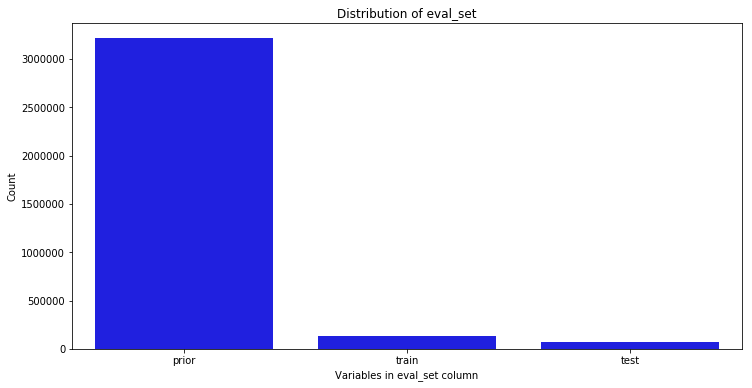

In [7]:
# Plotted the distribution of eval_set
print(orders_df["eval_set"].value_counts())
print(orders_df["eval_set"].value_counts(normalize = True))
plt.figure(figsize=(12, 6))
dist_class = sns.countplot(orders_df['eval_set'], color="b")
plt.title('Distribution of eval_set')
plt.xlabel('Variables in eval_set column')
plt.ylabel('Count')
plt.show()

So the given set of orders contains prior, train and test. "Orders" contains ~94% of prior orders, 3.8% train and 2.2% test orders.

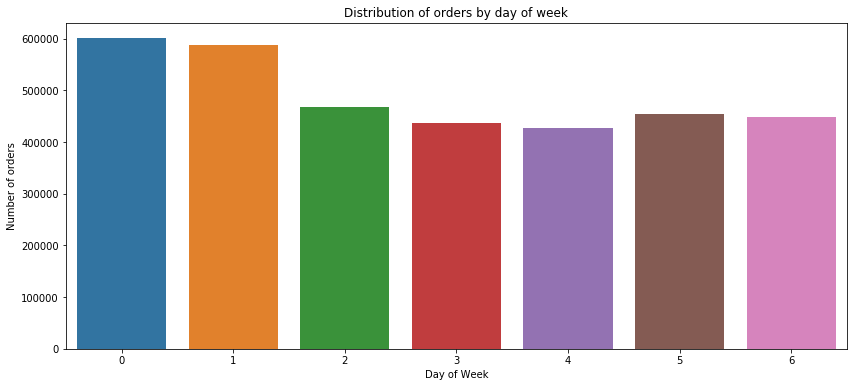

In [8]:
#Lets understand the distribution of orders over time. Lets first plot the distribution of order vs day of week
plt.figure(figsize=(14, 6))
dist_class = sns.countplot(orders_df['order_dow'])
plt.title('Distribution of orders by day of week')
plt.xlabel('Day of Week')
plt.ylabel('Number of orders')
plt.show()

Distribution of orders by day of week showed that the highest number of orders are placed on day 0 and day 1

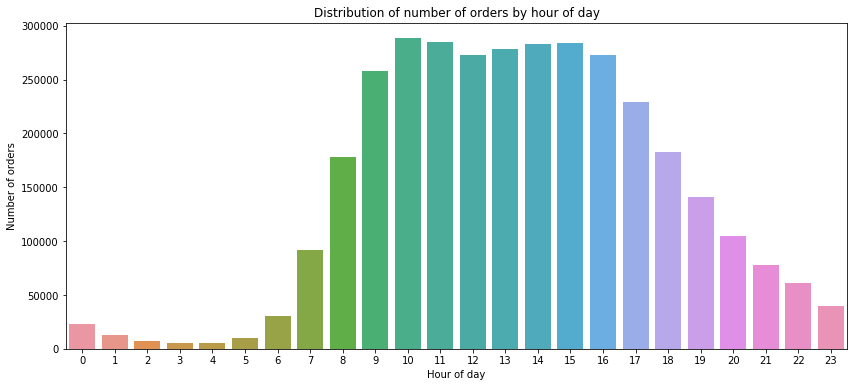

In [9]:
# Lets first plot the distribution of number of orders vs hour of day
plt.figure(figsize=(14, 6))
dist_class = sns.countplot(orders_df['order_hour_of_day'])
plt.title('Distribution of number of orders by hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Number of orders')
plt.show()

Distribution of orders vs hour of day showed that the number of orders are peaked during the day time. 

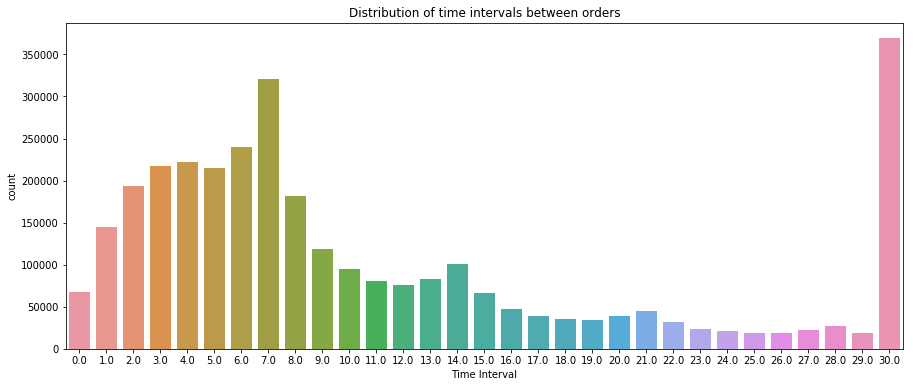

In [10]:
# Lets plot the distribution of time intervals between orders.
plt.figure(figsize=(15, 6))
dist_class = sns.countplot(orders_df['days_since_prior_order'])
plt.title('Distribution of time intervals between orders')
plt.xlabel('Time Interval')
plt.show()

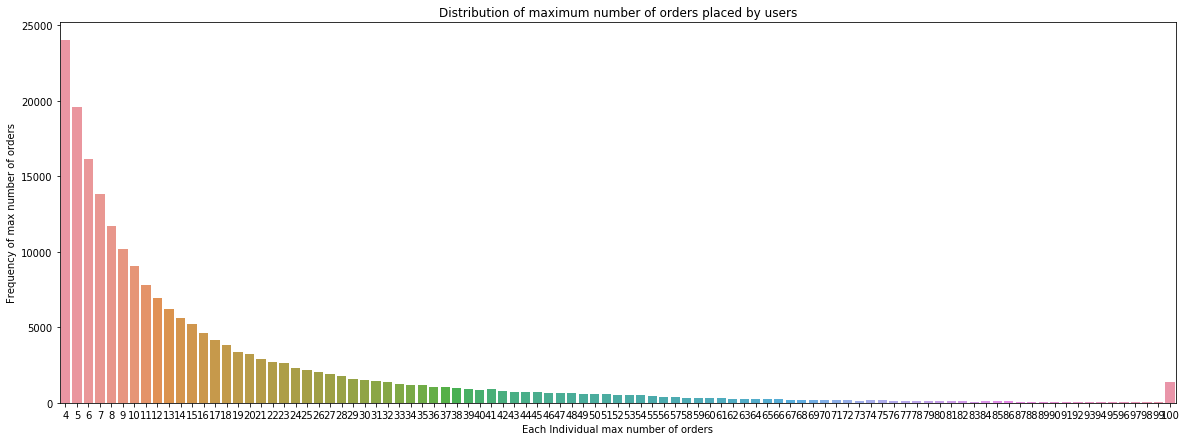

In [11]:
# Lets find the range of maximum number of orders placed by individual user
grouped_df = orders_df.groupby('user_id')['order_number']
# Get maximum values in each group
order_max = grouped_df.max().reset_index()
plt.figure(figsize=(20, 7))
dist_class = sns.countplot(order_max['order_number'])
plt.title('Distribution of maximum number of orders placed by users')
plt.xlabel('Each Individual max number of orders')
plt.ylabel('Frequency of max number of orders')
plt.show()

This distribution showed that maximum number of orders placed by users are ranged from 4 to 100

Lets understand the data provided in the products.csv

In [12]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Lets identify the top 20 products purchased by the users. In order to get this information we need to merge products dataframe with order_products_prior dataframe and then we can count the top 20 frequent number of products purchased.

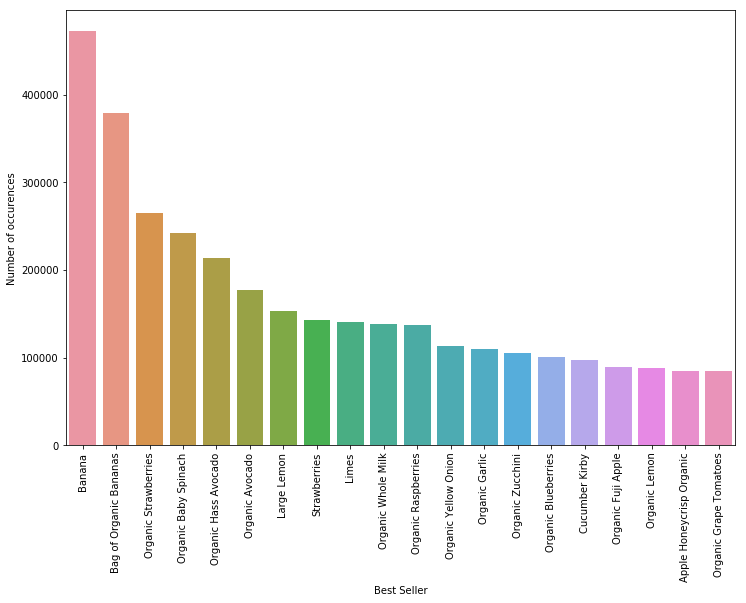

In [14]:
top_product = pd.merge(order_products_prior_df, products_df, on = 'product_id', how = 'left')
high_prch_list = top_product['product_name'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(high_prch_list.index, high_prch_list.values)
plt.xticks(rotation = "vertical")
plt.xlabel("Best Seller")
plt.ylabel("Number of occurences")
plt.show()

Wow, Instacart users seems like healthy and most of the top purchased products are organic. Our goal is to predict which products will be reordered. Lets find out the reorder percentage using order_products__prior and order_products__train datasets

Lets look at and join asile and department datasets to the top_product dataframe. 

In [15]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [16]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


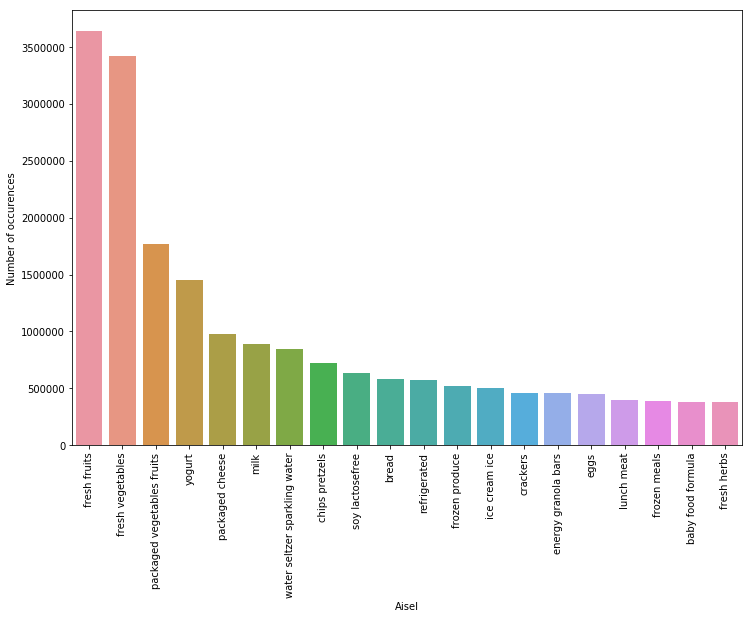

In [17]:
top_product = pd.merge(top_product, aisles_df, on = 'aisle_id', how = 'left')
top_product = pd.merge(top_product, departments_df, on = 'department_id', how = 'left')
# Lets find out the top purchased aisles
high_prch_aisle = top_product['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(high_prch_aisle.index, high_prch_aisle.values)
plt.xticks(rotation = "vertical")
plt.xlabel("Aisel")
plt.ylabel("Number of occurences")
plt.show()

Fruits and vegetables topped the list and its not surprise since majority of people will buy fruits and vegetables in grocery purchases. Lets find out the top purchased departments

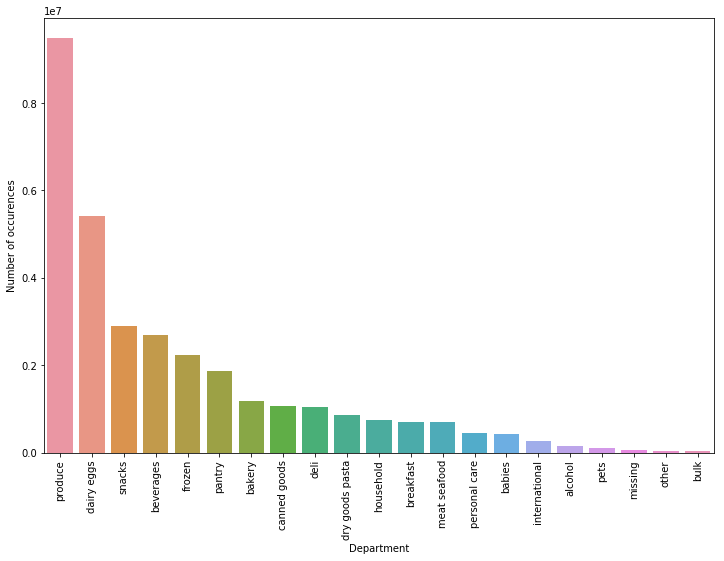

In [17]:
# Lets find out the top purchased aisle and department products
high_prch_department = top_product['department'].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(high_prch_department.index, high_prch_department.values)
plt.xticks(rotation = "vertical")
plt.xlabel("Department")
plt.ylabel("Number of occurences")
plt.show()

Distribution showed that produce and dairy eggs are top purchased products. Now lets jump into reorder percentages and try to understand the relations. 

In [18]:
reord_per_prior = top_product.reordered.sum()/len(top_product)
reord_per_prior

0.5896974667922161

In [19]:
reord_per_train = order_products_train_df.reordered.sum()/len(order_products_train_df)
reord_per_train

0.5985944127509629

Both datasets has the simlar reordered percentage of products which is close to 59%. This reordered percentage of products is for all order. Lets identify the percentage of orders which has no reodered items. 

In [20]:
grouped_prior = top_product.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_prior["reordered"].loc[grouped_prior["reordered"]>1] = 1
grouped_prior.reordered.value_counts() / grouped_prior.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

So 12% of orders in top_product dataset has orders which doesnt have any reorderes products. Lets check the order_products__train dataset to find out the same percentage. 

In [22]:
grouped_train = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_train["reordered"].loc[grouped_train["reordered"]>1] = 1
grouped_train.reordered.value_counts() / grouped_train.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

It seems the percentage of orders which doesnt have any reorderes products was cut down to half from 0.12% to 0.06% in order_products__train dataset. 

Lets try to identify relation between features of a dataset with reorders and try to get more intuation

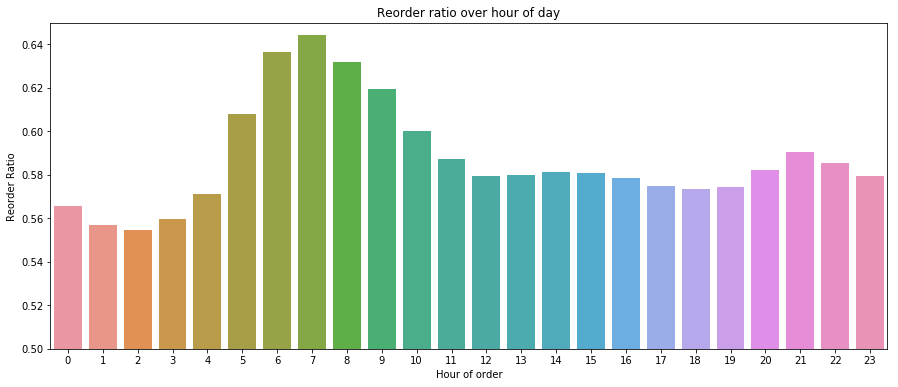

In [23]:
# Lets first start with finding the relation between day of hour and reorder ratio
final_df = pd.merge(top_product, orders_df, on = 'order_id', how = 'left')
grouped_prior = final_df.groupby("order_hour_of_day")["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(15, 6))
dist_class = sns.barplot(grouped_prior['order_hour_of_day'], grouped_prior['reordered'])
plt.title('Reorder ratio over hour of day')
plt.xlabel('Hour of order')
plt.ylabel('Reorder Ratio')
plt.ylim(0.5, 0.65)
plt.show()

Distribution showed that reorder ratio was high during the morning hours between 6 to 9. Okay, lets find out the relation between the reorder ratio and day of week.

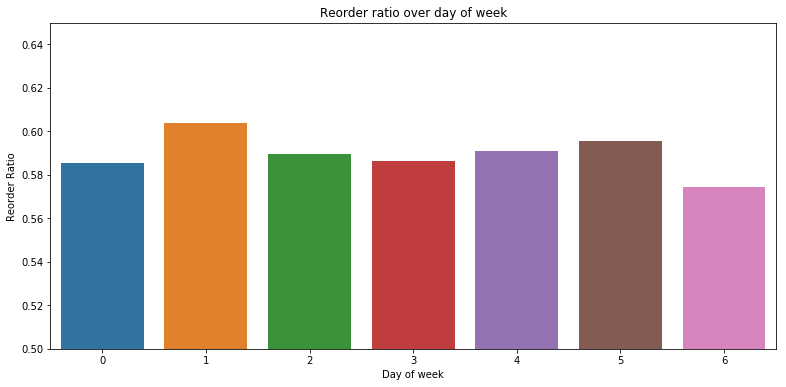

In [24]:
grouped_prior = final_df.groupby('order_dow')['reordered'].aggregate('mean').reset_index()
plt.figure(figsize=(13, 6))
dist_class = sns.barplot(grouped_prior['order_dow'], grouped_prior['reordered'])
plt.title('Reorder ratio over day of week')
plt.xlabel('Day of week')
plt.ylabel('Reorder Ratio')
plt.ylim(0.5, 0.65)
plt.show()

Reorder ratio is high on Sunday and Thursday. 

C:\Users\15832\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


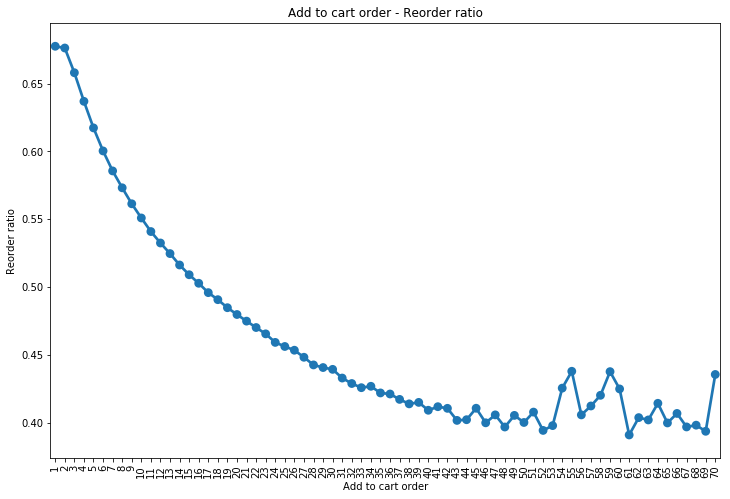

In [25]:
#Lets find out the relation between reorder ratio and add to cart
# The maximum value in order to cart is 145. To make it simple, lets consider the first 50 
# order to cart values in order to identify the relation between reoder ratio and add to cart
final_df["add_to_cart_order_mod"] = final_df["add_to_cart_order"].copy()
final_df["add_to_cart_order_mod"].loc[final_df["add_to_cart_order_mod"]>70] = 70
grouped_prior = final_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_prior['add_to_cart_order_mod'].values, grouped_prior['reordered'].values, alpha=0.8)
plt.ylabel('Reorder ratio')
plt.xlabel('Add to cart order')
plt.title("Add to cart order - Reorder ratio")
plt.xticks(rotation='vertical')
plt.show()

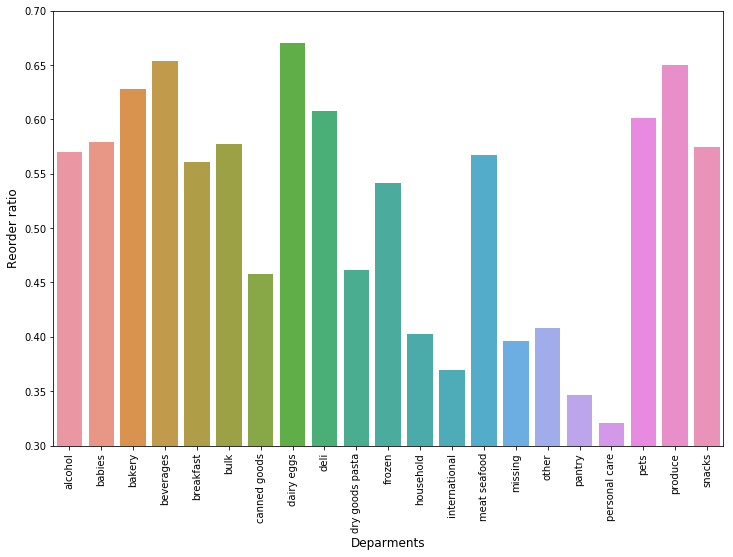

In [88]:
count = final_df.groupby("department")["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.barplot(count["department"].values, count["reordered"].values)
plt.xticks(rotation = "vertical")
plt.xlabel("Deparments", fontsize=12)
plt.ylabel("Reorder ratio", fontsize=12)
plt.ylim(0.3,0.7)
plt.show()

Distribution shows that the reorder ratio is high for the first added products. 
Lets understand the reorder realtion with departments

As expected dairy eggs have highet reorder ratio.

# Feature engineering

## Creating new features of users using user_id

In [27]:
#creating a datframe that will contain only prior information
op = pd.merge(orders_df, order_products_prior_df, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [28]:
tot_ordrs = op.groupby(by = 'user_id')['order_number'].aggregate('max').to_frame('usr_tot_ords').reset_index()
tot_ordrs.head()

,user_id,usr_tot_ords
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [29]:
# average number of products bought by the user in each purchase.

# First of all we need to count the products purchased in each order
tot_prdt = op.groupby(by = ['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('tot_prd').reset_index()
tot_prdt.head()

,user_id,order_id,tot_prd
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6


In [30]:
# Now, lets find the average number of products bought by the user in each purchase.
avg_prdt = tot_prdt.groupby(by = 'user_id')['tot_prd'].mean().to_frame('usr_avg_prdt').reset_index()
avg_prdt.head()

,user_id,usr_avg_prdt
0,1,5.900000
1,2,13.928571
2,3,7.333333
3,4,3.600000
4,5,9.250000


In [31]:
# Lets find out on which day of week user placed the highest number of orders
most_orders_dow = op.groupby(by='user_id')['order_dow'].agg(lambda x: stats.mode(x)[0]).to_frame('usr_most_orders_dow').reset_index()
most_orders_dow.head()

,user_id,usr_most_orders_dow
0,1,4
1,2,2
2,3,0
3,4,4
4,5,3


In [32]:
# Lets find out in which day of hour user placed the highest number of orders
most_orders_doh = op.groupby(by='user_id')['order_hour_of_day'].agg(lambda x: stats.mode(x)[0]).to_frame('usr_most_orders_doh').reset_index()
most_orders_doh.head()

,user_id,usr_most_orders_doh
0,1,7
1,2,9
2,3,16
3,4,15
4,5,18


In [33]:
# Lets merge the features created for users into a dataframe
users = tot_ordrs.merge(avg_prdt, on = 'user_id', how='left')
users = users.merge(most_orders_dow, on = 'user_id', how='left')
users = users.merge(most_orders_doh, on = 'user_id', how='left')
users.head()

,user_id,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh
0,1,10,5.900000,4,7
1,2,14,13.928571,2,9
2,3,12,7.333333,0,16
3,4,5,3.600000,4,15
4,5,4,9.250000,3,18


## Creating new features of products using product_id

In [34]:
del(avg_prdt, most_orders_dow, most_orders_doh)

In [35]:
# Lets find out the number of times each product was purchased by the user
prdt_cnt = op.groupby(by = 'product_id')['order_id'].agg('count').to_frame('prdt_cnt').reset_index()
prdt_cnt.head()

,product_id,prdt_cnt
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [36]:
# Lets find out the product reorder ratio
prdt_rdr = op.groupby(by = 'product_id')['reordered'].agg('mean').to_frame('prdt_rdr').reset_index()
prdt_rdr.head()

,product_id,prdt_rdr
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,5,0.600000


In [37]:
# Lets merge the newly created products into a dataframe
prdts = prdt_cnt.merge(prdt_rdr, on = 'product_id', how = 'left')
prdts.head()

,product_id,prdt_cnt,prdt_rdr
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,0.600000


In [38]:
del(prdt_cnt, prdt_rdr)

## Lets create the features related to user and product

In [39]:
# How many times a user bought the same product
usr_prdt_cnt_bought = op.groupby(by = ['user_id', 'product_id'])['order_id'].agg('count').to_frame('usr_prdt_cnt_bought').reset_index()
usr_prdt_cnt_bought.head()

,user_id,product_id,usr_prdt_cnt_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [40]:
# Lets find out the reorder ratio of the user for each product
usr_prdt_rdr = op.groupby(by = ['user_id', 'product_id'])['reordered'].agg('mean').to_frame('usr_prdt_rdr').reset_index()
usr_prdt_rdr.head()

,user_id,product_id,usr_prdt_rdr
0,1,196,0.900000
1,1,10258,0.888889
2,1,10326,0.000000
3,1,12427,0.900000
4,1,13032,0.666667


In [41]:
# Lets merge the newly created features using user_id & product_id into a dataframe
uxp = usr_prdt_cnt_bought.merge(usr_prdt_rdr, on = ['user_id','product_id'], how = 'left')
uxp.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr
0,1,196,10,0.900000
1,1,10258,9,0.888889
2,1,10326,1,0.000000
3,1,12427,10,0.900000
4,1,13032,3,0.666667


In [42]:
del(usr_prdt_cnt_bought, usr_prdt_rdr)

Lets merge all newly created features into a dataframe

In [43]:
data = uxp.merge(users, on ='user_id', how = 'left')
data = data.merge(prdts, on ='product_id', how = 'left')
data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158


In [44]:
del(users, prdts, uxp)

# Model Development and Testing:

## Lets create the train and test dataset

In [47]:
#keeping only the train and test eval set from the orders dataframe.
trn_or_tst = orders_df.loc[((orders_df.eval_set == 'train') | (orders_df.eval_set == 'test')), ['user_id', 'eval_set', 'order_id']]
trn_or_tst.head()

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797


In [48]:
# Lets merge the train and test eval set with the data
data = data.merge(trn_or_tst, on = 'user_id', how = 'left')
data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899


In [49]:
# Lets prepare the training data
train_data = data[data.eval_set == 'train']
train_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,eval_set,order_id
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899


In [50]:
# Lets get and add the reordered information from the order_proucts_train df into the data_train
train_data = train_data.merge(order_products_train_df[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
train_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,eval_set,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899,NaN
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899,NaN
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899,1.0


Lets fill NaN values in the reordered column

In [51]:
train_data.reordered.fillna(0, inplace=True)
train_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,eval_set,order_id,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,train,1187899,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,train,1187899,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,train,1187899,0.0
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,train,1187899,0.0
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,train,1187899,1.0


In [52]:
# Lets dropped unwanted columns which are not useful for training. 
train_data.drop(['eval_set', 'order_id'], axis=1, inplace=True)
train_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,0.0
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,0.0
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,1.0


In [53]:
train_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,reordered
0,1,196,10,0.900000,10,5.9,4,7,35791,0.776480,1.0
1,1,10258,9,0.888889,10,5.9,4,7,1946,0.713772,1.0
2,1,10326,1,0.000000,10,5.9,4,7,5526,0.652009,0.0
3,1,12427,10,0.900000,10,5.9,4,7,6476,0.740735,0.0
4,1,13032,3,0.666667,10,5.9,4,7,3751,0.657158,1.0


In [54]:
# Lets prepare the test data
test_data = data[data.eval_set == 'test']
test_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr,eval_set,order_id
120,3,248,1,0.000000,12,7.333333,0,16,6371,0.400251,test,2774568
121,3,1005,1,0.000000,12,7.333333,0,16,463,0.440605,test,2774568
122,3,1819,3,0.666667,12,7.333333,0,16,2424,0.492162,test,2774568
123,3,7503,1,0.000000,12,7.333333,0,16,12474,0.553551,test,2774568
124,3,8021,1,0.000000,12,7.333333,0,16,27864,0.591157,test,2774568


In [55]:
# Lets dropped unwanted columns. 
test_data = test_data.drop(['eval_set', 'order_id'], axis=1)
test_data.head()

,user_id,product_id,usr_prdt_cnt_bought,usr_prdt_rdr,usr_tot_ords,usr_avg_prdt,usr_most_orders_dow,usr_most_orders_doh,prdt_cnt,prdt_rdr
120,3,248,1,0.000000,12,7.333333,0,16,6371,0.400251
121,3,1005,1,0.000000,12,7.333333,0,16,463,0.440605
122,3,1819,3,0.666667,12,7.333333,0,16,2424,0.492162
123,3,7503,1,0.000000,12,7.333333,0,16,12474,0.553551
124,3,8021,1,0.000000,12,7.333333,0,16,27864,0.591157


In [56]:
#merging the aisles and department ids with the train and test data
train_data = train_data.merge(products_df[['product_id', 'aisle_id']], on='product_id', how='left')
test_data = test_data.merge(products_df[['product_id', 'aisle_id']], on='product_id', how='left')
#department
train_data = train_data.merge(products_df[['product_id', 'department_id']], on='product_id', how='left')
test_data = test_data.merge(products_df[['product_id', 'department_id']], on='product_id', how='left')

In [57]:
#setting user_id and product_id as index.
train_data = train_data.set_index(['user_id', 'product_id'])
train_data.head()

usr_prdt_cnt_bought  usr_prdt_rdr  usr_tot_ords  \
user_id product_id                                                    
1       196                          10      0.900000            10   
        10258                         9      0.888889            10   
        10326                         1      0.000000            10   
        12427                        10      0.900000            10   
        13032                         3      0.666667            10   

                    usr_avg_prdt  usr_most_orders_dow  usr_most_orders_doh  \
user_id product_id                                                           
1       196                  5.9                    4                    7   
        10258                5.9                    4                    7   
        10326                5.9                    4                    7   
        12427                5.9                    4                    7   
        13032                5.9                    4                    7   

                    prdt_cnt  prdt_rdr  reordered  aisle_id  department_id  
user_id product_id                                                          
1       196            35791  0.776480        1.0        77              7  
        10258           1946  0.713772        1.0       117             19  
        10326           5526  0.652009        0.0        24              4  
        12427           6476  0.740735        0.0        23             19  
        13032           3751  0.657158        1.0       121             14

In [58]:
test_data = test_data.set_index(['user_id', 'product_id'])
test_data.head()

usr_prdt_cnt_bought  usr_prdt_rdr  usr_tot_ords  \
user_id product_id                                                    
3       248                           1      0.000000            12   
        1005                          1      0.000000            12   
        1819                          3      0.666667            12   
        7503                          1      0.000000            12   
        8021                          1      0.000000            12   

                    usr_avg_prdt  usr_most_orders_dow  usr_most_orders_doh  \
user_id product_id                                                           
3       248             7.333333                    0                   16   
        1005            7.333333                    0                   16   
        1819            7.333333                    0                   16   
        7503            7.333333                    0                   16   
        8021            7.333333                    0                   16   

                    prdt_cnt  prdt_rdr  aisle_id  department_id  
user_id product_id                                               
3       248             6371  0.400251       117             19  
        1005             463  0.440605        94              7  
        1819            2424  0.492162        88             13  
        7503           12474  0.553551       117             19  
        8021           27864  0.591157        54             17

## Lets build and validate the model

In [59]:
#importing the necessary packages.
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances

#importing model packages.
import xgboost as xgb
import lightgbm as lgb

In [60]:
#splitting the train data into training and testing set.
X, y = train_data.drop('reordered', axis=1), train_data.reordered
#splitting dataset into train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [61]:
#setting boosters parameters
parameters = {
    'eavl_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

[18:41:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round, parameters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:41:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
F1 Score: 0.3934192619565277
             precision    recall  f1-score   support

          0       0.92      0.94      0.93   2244609
          1       0.43      0.36      0.39    297790

avg / total       0.86      0.87      0.86   2542399



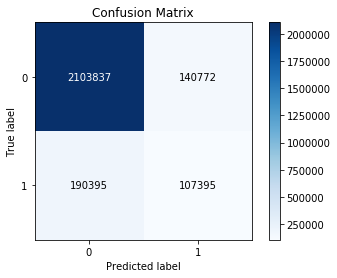

In [62]:
#Creating a XGBoost model.
# Initializing the model
xgb = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

#fitting the model.
xgb.fit(X_train, y_train)

#prediction
y_pred = (xgb.predict_proba(X_test)[:, 1] >= 0.21).astype('int') #setting a threshold.

#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))
plot_confusion_matrix(y_pred, y_test)

f1 score is 0.39 and there is definitely a chance of improving the model. 

In [64]:
#Fitting on entire data.
xgb.fit(X, y)

[19:21:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { num_boost_round, parameters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_boost_round=10, num_parallel_tree=1,
       objective='binary:logistic',
       parameters={'eavl_metric': 'logloss', 'max_depth': 5, 'colsample_bytree': 0.4, 'subsample': 0.8},
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       subsample=1, tree_method='approx', validate_parameters=1,
       verbosity=None)

In [69]:
#predicting on the testing data
y_pred = (xgb.predict_proba(test_data)[:, 1] >= 0.21).astype('int')
y_pred[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [71]:
#saving the prediction as a new column in data_test
test_data['prediction'] = y_pred
test_data.head()

usr_prdt_cnt_bought  usr_prdt_rdr  usr_tot_ords  \
user_id product_id                                                    
3       248                           1      0.000000            12   
        1005                          1      0.000000            12   
        1819                          3      0.666667            12   
        7503                          1      0.000000            12   
        8021                          1      0.000000            12   

                    usr_avg_prdt  usr_most_orders_dow  usr_most_orders_doh  \
user_id product_id                                                           
3       248             7.333333                    0                   16   
        1005            7.333333                    0                   16   
        1819            7.333333                    0                   16   
        7503            7.333333                    0                   16   
        8021            7.333333                    0                   16   

                    prdt_cnt  prdt_rdr  aisle_id  department_id  prediction  
user_id product_id                                                           
3       248             6371  0.400251       117             19           0  
        1005             463  0.440605        94              7           0  
        1819            2424  0.492162        88             13           0  
        7503           12474  0.553551       117             19           0  
        8021           27864  0.591157        54             17           0

Now we have predicted the products which can be buy/reordered again. Using the prediction data, we can also get the list of products that which can be recommended for each order

In [74]:
# Reset the index
final = test_data.reset_index()
# Keep only the required columns
final = final[['product_id', 'user_id', 'prediction']]
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [76]:
#Lets get the order_id for the test data
orders_test = orders_df.loc[orders_df.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [77]:
#merging our prediction with orders_test
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [81]:
#remove user_id column
#final = final.drop('user_id', axis=1)
final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [82]:
# Lets make a dictinary of orders(key) and products(values)
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
d

{2774568: '9387 17668 21903 39190 43961 47766',
 1528013: '21903 38293',
 1376945: '8309 8670 14947 27959 28465 33572 34658 35640 35948 42585 44632',
 1356845: '7076 10863 13176 14992 21616 28134',
 2161313: '196 10441 11266 12427 14715 27839 37710',
 1416320: '5134 17948 21137 21903 24852 28985 41950',
 1735923: '196 2192 12108 13249 14252 15131 17008 18174 24629 31487 34690 35123',
 1980631: '6184 9387 13575 13914 22362 41400 46061',
 139655: '13176 22935 27845',
 1411408: '22008 43758',
 2940603: '7521 14947 19894 30592 31615 44632',
 1192143: '24759 24852 47626',
 280888: '12440 19213 41406',
 3202221: '2452 4793 6069 7781 9203 9637 11130 13629 17630 21137 21927 24852 39911 45364 46979 49215',
 3222866: '7039 7969 8501 14947 15718 18894 32441 32912 33198 34254 35921 37131 38690',
 707453: '694 4942 18150 21137 21267 21903 24852 26209 28156 32030 37766 39275 42585 44142 44830 45066 46802 47766 48230',
 1320132: '11079 44632',
 882556: '1870 5373 5450 7371 8424 9076 12857 17794 21903

In [86]:
#Convert the dictionary into a DataFrame
result = pd.DataFrame.from_dict(d, orient='index')

#Reset index
result.reset_index(inplace=True)
#Set column names
result.columns = ['order_id', 'products']

result.head()

,order_id,products
0,2774568,9387 17668 21903 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 8670 14947 27959 28465 33572 34658 35640 ...
3,1356845,7076 10863 13176 14992 21616 28134
4,2161313,196 10441 11266 12427 14715 27839 37710


In [87]:
#save the result on desktop 
result.to_csv('C:/Users/15832/Downloads/projects/Advisory/FD Superset/result.csv', index=False)

C:\Users\15832\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_feature_importances is deprecated; This will be removed in v0.4.0. Please use scikitplot.estimators.plot_feature_importances instead.
  warnings.warn(msg, category=DeprecationWarning)


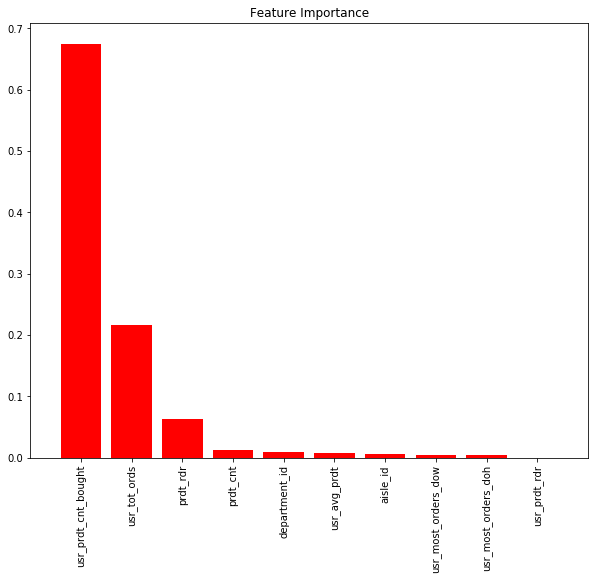

In [82]:
#plotting feature importance.
plot_feature_importances(xgb, feature_names=test_data.columns, x_tick_rotation=90, max_num_features=20, figsize=(10,8))

# Conclusion:
As part of the next steps, lets focus more on the feature engineering to improve the accuracy of XGBoost and try to evaluate some other machine learning models which can make better prediction with high accuracy.